<h1><center> Домашняя работа #3</center></h1>

(Дополнительное решение через Ray RLlib)

Описание задачи на сайте Gymnasium ([ссылка](https://gymnasium.farama.org/environments/box2d/lunar_lander/))

## Imports

In [1]:
1 + 1

2

In [2]:
!nvidia-smi

Fri Dec 19 07:33:09 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   35C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
# ModuleNotFoundError: No module named 'tree'. How to fix:
# https://github.com/ray-project/ray/issues/7645#issuecomment-1946668428
# 1. pip uninstall -y tree
# 2. pip uninstall -y dm-tree
# 3. pip install --upgrade ray
# 4. pip install dm-tree

In [4]:
# %pip install ray dm-tree

In [5]:
# %pip install lz4 "ray[tune]" tensorboardX

In [6]:
# %pip install swig Box2D

In [7]:
import warnings

warnings.filterwarnings("ignore")

In [30]:
import os

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ray
import ray.rllib.algorithms.ppo as ppo
import torch

from gymnasium.wrappers import (
    ResizeObservation,
)

from ray.tune.registry import register_env
from ray.rllib.utils.metrics import (
    ENV_RUNNER_RESULTS,
    EPISODE_RETURN_MEAN,
)
from tqdm import trange

## Environment

**Observation space:**

A top-down 96x96 RGB image of the car and race track.

**Actions:**

- 0: steering, -1 is full left, +1 is full right
- 1: gas
- 2: braking

The three numbers (in order) are:

1. Steering
   - Range: [-1.0, 1.0]
   - Negative values: turn left
   - Positive values: turn right
2. Acceleration (Gas)
   -  Range: [0.0, 1.0]
   - 0 = no acceleration
   - 1 = full acceleration
3. Brake
    -  Range: [0.0, 1.0]
   - 0 = no braking
   - 1 = full braking

---

Example Actions:

- [0.0, 0.5, 0.0] → Go straight, accelerate at 50% power, no brake.
- [-0.8, 0.1, 0.0] → Sharp left turn, low acceleration.
- [0.3, 0.0, 0.7] → Gentle right turn, no gas, brake at 70%.

**Rewards:**

The reward is -0.1 every frame and +1000/N for every track tile visited, where N is the total number of tiles visited in the track. For example, if you have finished in 732 frames, your reward is 1000 - 0.1*732 = 926.8 points.

---
## Model

In [9]:
class CarRacingContinuousEnv(gym.Wrapper):
    """
    Wrapper for continuous CarRacing with normalized observations
    """

    def __init__(self, *args):

        env = gym.make("CarRacing-v3", render_mode="rgb_array")
        env = ResizeObservation(env, shape=(84, 84))

        super().__init__(env)

        # Store original action space for reference
        self.original_action_space = env.action_space

        # Normalize observation space (96x96x3 uint8 -> float32 [0,1])
        self.observation_space = gym.spaces.Box(
            low=0.0, high=1.0, shape=env.observation_space.shape, dtype=np.float32
        )

    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        return obs.astype(np.float32) / 255.0, info

    def step(self, action):
        obs, reward, terminated, truncated, info = self.env.step(action)
        obs_normalized = obs.astype(np.float32) / 255.0
        return obs_normalized, reward, terminated, truncated, info

In [10]:
def env_creator(config):
    return CarRacingContinuousEnv(config)


register_env("my_env", env_creator)

In [11]:
ray.init(ignore_reinit_error=True)

2025-12-19 07:33:35,308	INFO worker.py:2023 -- Started a local Ray instance.


Python version:,3.12.12
Ray version:,2.52.1


In [12]:
if torch.cuda.is_available():
    num_gpus = torch.cuda.device_count()

In [13]:
suggested_workers = 1  # os.cpu_count()

In [15]:
config = ppo.PPOConfig()

config = (
    config.framework("torch")
    .resources(num_gpus=num_gpus)
    .env_runners(
        num_cpus_per_env_runner=1,
        num_env_runners=suggested_workers,
        rollout_fragment_length="auto",
    )
    .training(
        model={
            "conv_filters": [
                [16, [4, 4], 2],
                [32, [4, 4], 2],
                [64, [4, 4], 2],
                [128, [11, 11], 1],
            ],
            "fcnet_hiddens": [256, 256],
            "fcnet_activation": "tanh",
            "conv_activation": "relu",
            "post_fcnet_activation": "tanh",
        },
        lr=3e-4,
        train_batch_size=1024,
        num_epochs=8,
        gamma=0.99,
        grad_clip=0.7,
        grad_clip_by="norm",
    )
    .environment(
        env="my_env",
    )
    .api_stack(
        enable_rl_module_and_learner=True, enable_env_runner_and_connector_v2=True
    )
)

In [16]:
trainer = config.build_algo()

2025-12-19 07:33:58,050	WARNING algorithm_config.py:5058 -- You are running PPO on the new API stack! This is the new default behavior for this algorithm. If you don't want to use the new API stack, set `config.api_stack(enable_rl_module_and_learner=False,enable_env_runner_and_connector_v2=False)`. For a detailed migration guide, see here: https://docs.ray.io/en/master/rllib/new-api-stack-migration-guide.html
2025-12-19 07:33:58,054	WARNING algorithm_config.py:5087 -- You configured a custom `model` config (probably through calling config.training(model=..), whereas your config uses the new API stack! In order to switch off the new API stack, set in your config: `config.api_stack(enable_rl_module_and_learner=False, enable_env_runner_and_connector_v2=False)`. If you DO want to use the new API stack, configure your model, instead, through: `config.rl_module(model_config={..})`.
(pid=6720) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=6720) E0

In [26]:
num_episodes = 10

In [27]:
episode_rewards = []

for i in trange(num_episodes):
    result = trainer.train()
    episode_rewards.append(result[ENV_RUNNER_RESULTS][EPISODE_RETURN_MEAN])
    # todo: add printing for higher number of episodes

100%|██████████| 10/10 [28:30<00:00, 171.07s/it]


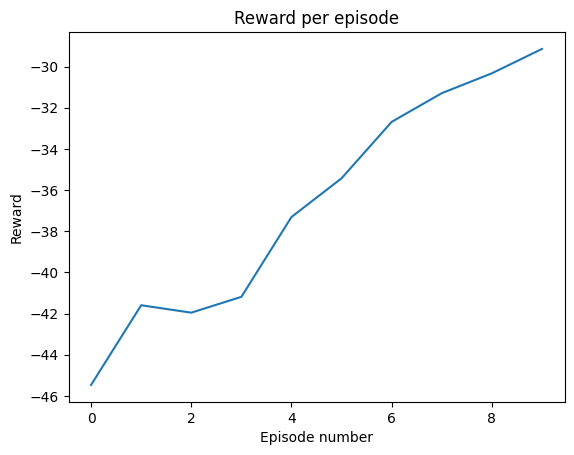

In [31]:
plt.plot(episode_rewards)
plt.ylabel("Reward")
plt.xlabel("Episode number")
plt.title("Reward per episode")
plt.show()